In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

import torchgp
from utils import get_data, plot_result

In [2]:
init_output_scale = 1.0
init_input_scale = 0.8
init_noise_variance = 0.001
num_pseudo = 10

In [3]:
x_train, y_train, x_test, batch_size = get_data()

In [4]:
x_pseudo = np.linspace(-2, 12, num_pseudo).reshape(-1, 1)
kernel = torchgp.kernels.GaussianKernel(input_scale=init_input_scale, output_scale=init_output_scale)
model = torchgp.models.OSGPRModel(x_pseudo, kernel, noise_variance=init_noise_variance)
batch_model = torchgp.models.SGPRModel(x_pseudo, kernel, noise_variance=init_noise_variance)

Training SGPR on the full dataset takes  0.50 seconds
Training OSGPR on batch 0 takes  0.12 seconds
Training OSGPR on batch 1 takes  0.35 seconds
Training OSGPR on batch 2 takes  0.16 seconds


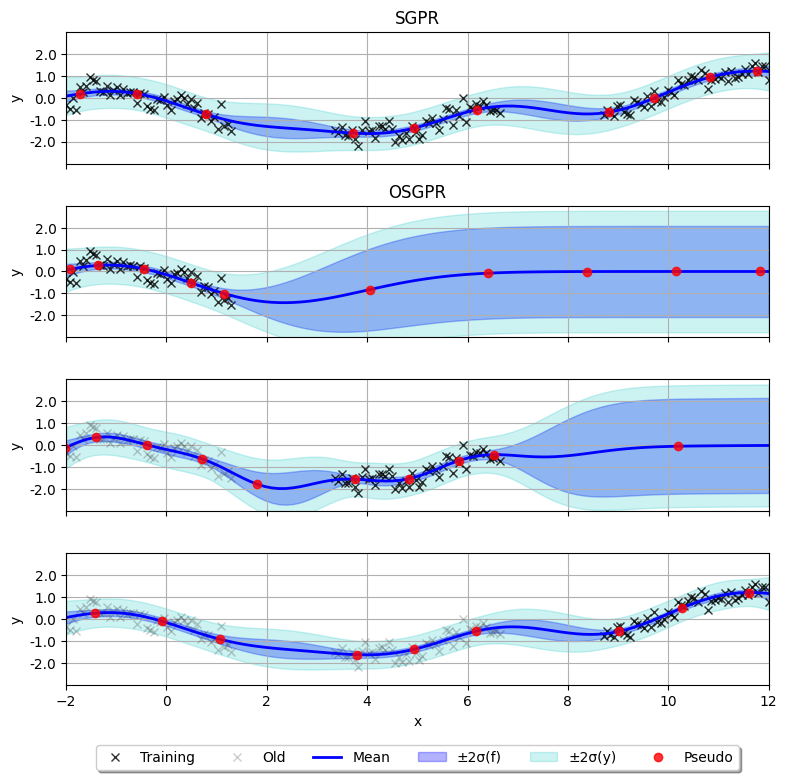

In [5]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 8))
# Learning
start = time()
batch_model.add_data(x_train, y_train)
batch_model.learn()
end = time()
print(f"Training SGPR on the full dataset takes {end - start: .2f} seconds")
# Prediction
mean, var = batch_model.predict(x_test, include_likelihood=False)
# Visualization
plot_result(
    axes[0],
    x_train,
    y_train,
    x_test,
    mean,
    var,
    batch_model.likelihood.noise_variance.item(),
    batch_model.x_pseudo,
    batch_model.f_pseudo,
)
axes[0].grid()
axes[0].set_title("SGPR")
axes[1].set_title("OSGPR")
for batch_index in range(3):
    x_batch = x_train[batch_index * batch_size : (batch_index + 1) * batch_size, :]
    y_batch = y_train[batch_index * batch_size : (batch_index + 1) * batch_size, :]
    # Learning
    start = time()
    model.add_data(x_batch, y_batch)
    model.learn()
    end = time()
    print(f"Training OSGPR on batch {batch_index} takes {end - start: .2f} seconds")
    # Prediction
    mean, var = model.predict(x_test, include_likelihood=False)
    # Visualization
    plot_result(
        axes[batch_index + 1],
        x_batch,
        y_batch,
        x_test,
        mean,
        var,
        model.likelihood.noise_variance.item(),
        model.x_pseudo,
        model.f_pseudo,
        x_old=x_train[: batch_index * batch_size, :] if batch_index > 0 else None,
        y_old=y_train[: batch_index * batch_size, :] if batch_index > 0 else None,
        plot_legend = True if batch_index == 2 else False,
    )
    axes[batch_index + 1].grid()
axes[3].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.7),
    fancybox=True,
    shadow=True,
    ncol=6,
)
axes[3].set_xlabel("x")
fig.tight_layout()
plt.show()